# PCA for dimension reduction

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

## image dataset

In [2]:
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
n_samples,h,w = faces.images.shape

In [4]:
n_samples,h,w

(1217, 50, 37)

In [5]:
faces.data.shape

(1217, 1850)

In [6]:
faces.target

array([3, 1, 0, ..., 5, 3, 5])

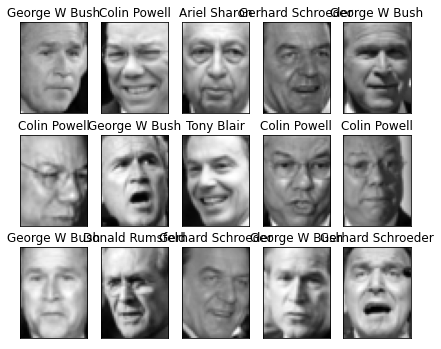

In [7]:
fig = plt.figure(figsize=(7,10))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=12)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

## compress images

In [8]:
X = faces.data
y = faces.target

In [9]:
pca = PCA(n_components=150) #dataset is projected into 150 pc
data_projected = pca.fit_transform(X) # no 1850 pixels, but only 150

In [10]:
pca.components_.shape

(150, 1850)

In [11]:
data_projected.shape

(1217, 150)

In [12]:
data_reconstructed = pca.inverse_transform(data_projected)

In [13]:
data_reconstructed.shape

(1217, 1850)

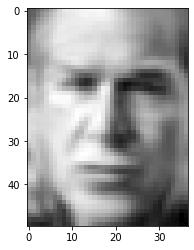

In [14]:
plt.imshow(data_reconstructed[13].reshape((h,w)),cmap=plt.cm.gray)

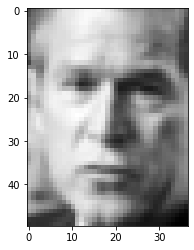

In [15]:
plt.imshow(faces.images[13],cmap=plt.cm.gray)

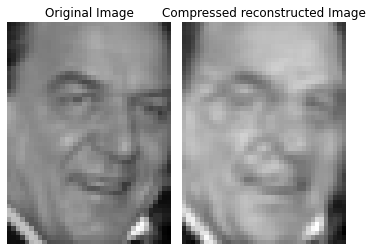

In [16]:
# manually do the multiplication 

num_dimensions = 150

# We do our reconstruction over the 13th image
image_original = faces.images[12];
image_compressed = data_projected[12];

# we start the reconstruction from the mean over all images (feel free to print mean face to check!)
image_reconstructed = pca.mean_.copy(); 

# Then, reconstruct the image by doing the sum of every 150 entry of its compressed representation,
# weighted by the corresponding principal components
for i in range(num_dimensions):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    
# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 2, figsize = (5,5))
ax[0].imshow(image_original, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap=plt.cm.gray)
ax[1].set_title('Compressed reconstructed Image')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

## mean face

Every image can be represented by the "mean face" plus a linear combination of the 150 "PC faces".

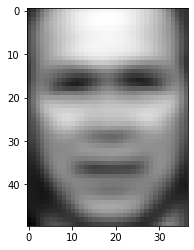

In [17]:
plt.imshow(pca.mean_.reshape(h,w),cmap=plt.cm.gray)

In [18]:
pca.components_.shape

(150, 1850)

In [19]:
pca.components_[0].shape

(1850,)

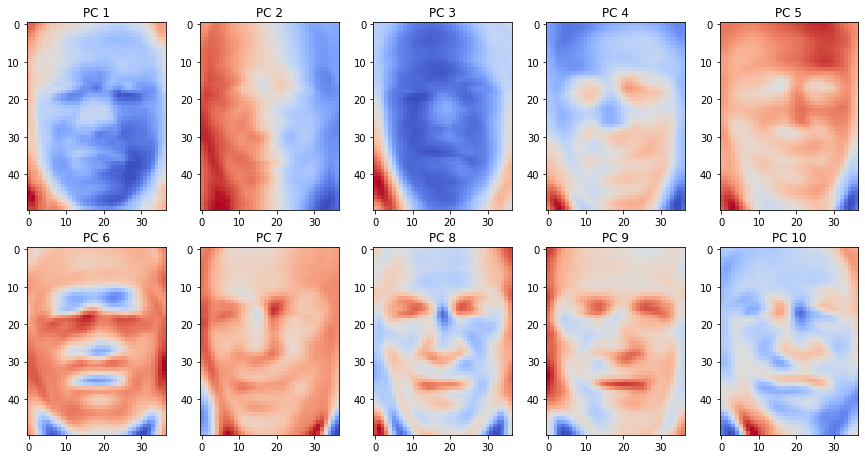

In [20]:
fig = plt.figure(figsize=(15,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.title(f'PC {i+1}',size=12)
    plt.imshow(pca.components_[i].reshape((h,w)),cmap=plt.cm.coolwarm)

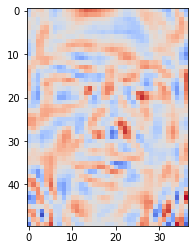

In [21]:
plt.imshow(pca.components_[-1].reshape((h,w)),cmap=plt.cm.coolwarm)

## classifier model (PCA as feature engineering)

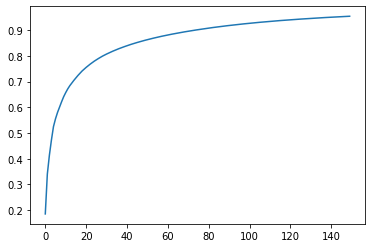

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

This curve quantifies how much of the total variance is contained within the first components. For example:
- The first 20 components contain more than 75% of the variance,
- while we need about only 70 components to describe 90% of the variance!

In [23]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum[cumsum<=0.8]

array([0.18557714, 0.34048808, 0.4134733 , 0.47275826, 0.5248945 ,
       0.5554256 , 0.58037055, 0.60176605, 0.62207043, 0.6413926 ,
       0.6573856 , 0.67177564, 0.6841613 , 0.6948686 , 0.7050336 ,
       0.7149032 , 0.7240919 , 0.7328449 , 0.74118793, 0.74837166,
       0.7553396 , 0.761945  , 0.7681208 , 0.7740884 , 0.77966845,
       0.7848578 , 0.7897867 , 0.79456   , 0.79910254], dtype=float32)

In [24]:
minimal_pc_count = len(cumsum[cumsum<=0.8])+1
minimal_pc_count

30

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [26]:
pca = PCA(n_components=150).fit(X_train)

In [27]:
X_train_transform = pca.transform(X_train)
X_test_transform = pca.transform(X_test)

In [28]:
# first gridsearch for svc

param_grid = {
    'kernel':['linear','poly','rbf','sigmoid'],
    'C':np.logspace(1,4,4),
    'gamma':np.logspace(-4,-1,4)
}

In [29]:
search = GridSearchCV(SVC(class_weight='balanced'),
                      param_grid,
                      cv=5,
                      scoring='f1_weighted',
                      n_jobs=-1)

In [30]:
search.fit(X_train_transform,y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([   10.,   100.,  1000., 10000.]),
                         'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_weighted')

In [31]:
search.best_estimator_

SVC(C=10.0, class_weight='balanced', gamma=0.0001, kernel='linear')

In [32]:
search.best_score_

0.8097437062480394

In [33]:
best_model = search.best_estimator_

In [34]:
y_pred = best_model.predict(X_test_transform)

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.87      0.83      0.85        70
           2       0.66      0.77      0.71        30
           3       0.88      0.90      0.89       159
           4       0.85      0.80      0.83        41
           5       0.79      0.76      0.77        41

    accuracy                           0.84       366
   macro avg       0.81      0.81      0.81       366
weighted avg       0.84      0.84      0.84       366



In [36]:
pipeline = make_pipeline(PCA(),SVC(class_weight='balanced'))

In [37]:
pipeline.get_params()

{'memory': None,
 'steps': [('pca', PCA()), ('svc', SVC(class_weight='balanced'))],
 'verbose': False,
 'pca': PCA(),
 'svc': SVC(class_weight='balanced'),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': 'balanced',
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [38]:
# second gridsearch for pipeline
grid = {
    'pca__n_components':range(200,600,1),
    'svc__kernel':['linear'],
    'svc__C':[10.0],
    'svc__gamma':[0.0001]
}

In [39]:
pipe_search = GridSearchCV(pipeline,grid,cv=5,scoring='f1_weighted')

In [44]:
pipe_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'pca__n_components': range(200, 600), 'svc__C': [10.0],
                         'svc__gamma': [0.0001], 'svc__kernel': ['linear']},
             scoring='f1_weighted')

In [42]:
pipe_search.best_score_

nan

In [43]:
pipe_search.best_params_

{'pca__n_components': 200,
 'svc__C': 10.0,
 'svc__gamma': 0.0001,
 'svc__kernel': 'linear'}